# COMP2006: Graded Lab 5

In this lab, you will gain further experience in dealing with missing data and further practice converting non-numeric features in a dataset to numeric, as well as, exploring ways to increase model performance through data set improvement.

**Target**: `Comb Unadj FE - Conventional Fuel`

**Data set**: make sure you use the data assigned to your group!

| Groups | Data set |
| :-: | :-: |
| 1 | vehicles_1.csv |
| 2 | vehicles_2.csv |
| 3 | vehicles_3.csv |
| 4 | vehicles_4.csv |
| 5 | vehicles_5.csv |
| 6 | vehicles_6.csv |
| 7 | vehicles_7.csv |
| 8 | vehicles_8.csv |
| 10 | vehicles_10.csv |


**Important Notes:**
- **Only provide FINAL code in each Part of the lab**
    - I only want to see final, well-organized code in your submission
- Only need to use **random forest** models
    - All random forest models should include 150 decision trees
- Use the **out-of-bag score** to evaluate models
     - Read Section 5.2 carefully so that you use this method properly
     - The oob score that you provide should be the average of 10 runs
     - **If you use `train_test_split()` or calculate MSE or MAE you will have marks deducted!**
- Code submitted for this lab should be:
     - error free
         - to make sure this is the case, before submitting, close all Jupyter notebooks, exit VS COde, reload the lab notebook and execute all cells
     - final code
         - this means that I don't want to see every piece of code you try as you work through this lab but only the final code; only the code that fulfills the objective
- Don't make assumptions!
- Information about the data can be found at [this website](https://www.fueleconomy.gov/feg/download.shtml)



**A few tips**
 - The function `sniff_modified` (from lecture notebooks) will probably come in handy
 - If you use `dropna`, it may be worthwhile exloring the `thresh` parameter
 - If you use `.info()`, you might need to set the `verbose` parameter
 - List comprehensions (or other programmatic methods) might be helpful in trying to select columns: `[f for f in df.columns if 'some_text' in f]`
 - And you don't have to get all the columns of interest in one go because `['a', 'b'] + ['c', 'd'] = ['a', 'b', 'c', 'd']`
 - If a feature has only 1 unique element how long would the list `df[col].unique()` be?
 - To help in viewing the data, you may find these commands helpful (see [here](https://thispointer.com/python-pandas-how-to-display-full-dataframe-i-e-print-all-rows-columns-without-truncation/) for explanation):
    - `pd.set_option('display.max_rows', None)`
    - `pd.set_option('display.max_columns', None)`
    - `pd.set_option('display.width', None)`
    - `pd.set_option('display.max_colwidth', None)`
 - start simple; then build up complexity, but only if needed

## Part 0
***
### Group Number 7
 - Manuel Bishop Noriega - ID 4362207
 - Robert E. Matney III - ID: 4364229
***
     

In [1249]:
import pandas as pd
# from rfpimp import *
from rfpimp_MC import *
from pandas.api.types import is_string_dtype, is_object_dtype
from pandas.api.types import is_categorical_dtype
import category_encoders as ce
from sklearn.ensemble import RandomForestRegressor
import warnings # to avoid some warnings about plots
warnings.filterwarnings('ignore')

# ------------------------------------------- HELPER FUNCTIONS ----------------------------------------------

# ------------------------------------------- EVALUATE FUNCTION ---------------------------------------------
# to prevent repeating code we created an evaluation function called evaluate # it will take features and
# target as parameters and use them to create and fit a random forest regressor model and calculate it's
# oob performance. It returns a tuple with rf model and its oob average from 10 runs
def evaluate(X,y):
    oob_scores = []
    for i in range(10):
        rf = RandomForestRegressor(n_estimators=150, n_jobs=-1, oob_score=True)
        rf.fit(X, y)
        oob_scores.append(rf.oob_score_)
    oob=sum(oob_scores) / len(oob_scores)
    print(f'Mean OOB score: {oob}')
    print(f'{rfnnodes(rf):,d} tree nodes and {np.median(rfmaxdepths(rf))} median tree height')
    return rf, oob

# ----------------------------------------- FEATURES IMPORTANCES --------------------------------------------
# showimp() show features importances, it accepts up to 4 params
# rf: a randomforest regressor
# X,y are the features and target
# features, I added this to perform different tests while converting non-numeric features
# plots the features' importances graphic
def showimp(rf,X,y):
    I=importances(rf,X,y)
    plot_importances(I,color='blue')
    return I

# --- we took this function from book, useful to quickly identify most obvious missing values in dataset ---
def sniff(df):
    # with pd.option_context("display.max_colwidth",20):
        info=pd.DataFrame()
        #info['sample']=df.iloc[120] #no needed here
        info['data type']=df.dtypes
        info['percent missing']=df.isnull().sum()*100/len(df)
        info['No. unique'] = df.apply(lambda x: len(x.unique()))
        info['unique values'] = df.apply(lambda x: x.unique())
        return info.sort_values('data type')

# ---------------- we'll use this many times during this lab, so we're saving keystrokes -------------------
def get_unique_values_in_columns(df):
     print('PRINTING UNIQUE VALUES PER COLUMN\n')
     for col in df.columns:
        print(f'{col} : {df[col].value_counts()} {df[col].unique()}')
        #  print(f'{col} : ')

#--------------------------------------- FUNCTIONS TO NORMALIZE --------------------------------------------
#                           missing values in numeric and non-numeric features
# NON-NUMERIC FEATURES: receives dataframe to normalize and a string with all values to replace
# and returns it 
def normalize_nonum(df,missing_values_str):   
    for col in df.columns:
        df[col]=df[col].str.lower()
        df[col]=df[col].fillna(np.nan)
        df[col]=df[col].replace(missing_values_str, np.nan)
    return df
# SET ALL VALUES IN NON-NUMERIC FEATURES TO LOWERCASE
def to_lower(df):   
    for col in df.columns:
        if is_object_dtype(df[col]):
            df[col]=df[col].str.lower()
    return df
    

# NUMERIC FEATURES: receives the dataframe to normalize and returns it
def normalize_num(df):
    for col in df.columns:
        df[col]=df[col].replace(0,np.nan)
    return df

# --------------------------------------- FUNCTIONS TO LABEL ENCODE -----------------------------------------
#                non-numeric features as ordinal, taken from book, this will fix missing values
# this converts dtype for each column to ordinal category.
def df_string_to_cat(df):
    for col in df.columns:
        if is_object_dtype(df[col]):
            df[col] = df[col].astype('category').cat.as_ordered()
    return df
# this loop transform nominal values in to integers according to categories previously assigned
def df_cat_to_catcode(df):
    for col in df.columns:
        if is_categorical_dtype(df[col]):
            df[col] = df[col].cat.codes + 1
    return df

# ------------------------- FUNCTION TO HANDLE MISSING VALUES ---------------------------
#                in numeric features based on the one showed in the book.
def fix_missing_num(df):
    r=df.isna().any()  # get the columns with missing values
    msvrows=r[r==True].index
    for e in msvrows:       #now loop through those columns and replace missing values with median
        df[e+'_na']=pd.isnull(df[e])
        df[e].fillna(df[e].median(), inplace=True)

In [1250]:
# PART ONE
#-------------------------- reading data from csv file ----------------------
df = pd.read_csv("vehicles_7.csv")

## Part 1: Initial data clean-up (5 marks per Step)

In this part, you will follow the steps below to do an initial clean-up of the data.

##### Step 1: Remove target related features

The data contains some features that are essentially equivalent to the target. If we leave them in, they will leak information about the target to the model and the model performance will be erroneously high. Columns with a date are also not helpful here. In this step, we will remove any feature that contains:
 - 'rating'
 - 'ghg'
 - 'mpg'
 - 'co2'
 - 'alternative fuel'
 - 'conventional fuel' (except for the actual target!)
 - 'fuel costs'
 - 'date'

If you still get a very high oob score (approx. = 1) then you should check for other features that may also be equivalent to the target and remove them also. 

In [1251]:
print(f'Dataset shape for raw dataset: {df.shape}')
# now remove all unwanted columns, target feature will be dropped here too, then we'll get it back from df lately
X=df.drop(df.columns.where(df.columns.str.contains('ghg|rating|mpg|co2|alternative fuel|conventional fuel|fuel costs|date',case=False),np.nan).dropna(),axis=1)
print(f'Dataset shape after removing indicated features: {X.shape}')

Dataset shape for raw dataset: (1196, 162)
Dataset shape after removing indicated features: (1196, 96)


In [1252]:
# we'll prepare our target feature and keep it in y variable to use it later, because it has some missing values we'll replace them with 0's
y=pd.to_numeric(df['Comb Unadj FE - Conventional Fuel'],errors='coerce',downcast='float') # if it's not a number then replace it with NaN
target_feature=['Comb Unadj FE - Conventional Fuel']
y=y.fillna(0) # can't have missing values in y, then fill in them with 0
print(f'Missing values not filled in with 0 in target feature? : {y.isna().any()}')



Missing values not filled in with 0 in target feature? : False


##### Step 2: Remove features with 90% or more missing values

The data contains some features that have a lot of missing values. Remove any feature that has 90% or more missing values. There is nothing magical about this number. We are simply picking a starting threshold. In a real-world scenario we would probably need to revisit and justify this threshold, but for now we will use it to get started. 

In [1253]:
X=X.drop((sniff(X)['percent missing']>90).loc[lambda x:x==True].index,axis=1)
print(f'Dataset shape after removing features with >90% missing values: {X.shape}')

Dataset shape after removing features with >90% missing values: (1196, 52)


##### Step 3: Convert all string/object features to lower case

If any categorical feature contains both 'Yes' and 'yes', we want our model to treat these as the same. To do that, we need to convert all string/objet type features to lower case. (*Hint*: If you use a function for this, make sure it returns a data frame.) 

In [1254]:
#use function built for this purpose
X=to_lower(X)

##### Step 4: Remove any feature with only 1 unique value

If any feature contains only a single value, then our model will not be able to use this feature to help it predict our target, since there will be no pattern to discover. These features can be removed from the data. 

In [1255]:
# removing features with same value in all rows
X=X.drop((sniff(X)['No. unique']==1).loc[lambda x:x==True].index,axis=1)
# as commented in class, we decided to drop features having all rows with a unique value (such a row ID), because they won't help to much to make predictions
# just in case, we tested our baseline model with and without this features and there was no relevant difference in the oob
X=X.drop((sniff(X)['No. unique']==X.shape[0]).loc[lambda x:x==True].index,axis=1)
X.shape

(1196, 48)

In [1256]:
print(f'ORINGINAL DATASET:\nShape: {df.shape}\nNumeric features: {sniff(df)['data type'].value_counts()[1:3].sum()} -- Non-numeric features: {sniff(df)['data type'].value_counts()[:1].sum()}')
print(f'CLEANED DATASET:(Excluding target feature)\nShape {X.shape}\nNumeric features: {sniff(X)['data type'].value_counts()[1:3].sum()} -- Non-numeric features: {sniff(X)['data type'].value_counts()[:1].sum()}')

ORINGINAL DATASET:
Shape: (1196, 162)
Numeric features: 83 -- Non-numeric features: 79
CLEANED DATASET:(Excluding target feature)
Shape (1196, 48)
Numeric features: 12 -- Non-numeric features: 36


##### Step 5: Compare data sets

Compare some basic characteristics between our original data set and the one after our initial clean up. Fill in the table below:

| Characteristic | Original data set | After initial clean-up |
| :- | :- | :- |  
|  # rows  |  1196   | 1196  | 
|  # columns  |  162   | 48  | 
|  # numeric features |   83  | 12  | 
|  # non-nonumeric features |  79   | 36  | 

### Part 2 - Create and evaluate an initial model (5 marks)

In this part you should: 
 - use the cleaned-up version of the data from **Part 1**
 - isolate all numeric features from the data set 
 - fill in any missing values with 0
 - create and evaluate a baseline model 

In [1257]:
# extracting numeric features from cleaned-up dataset
X_num=X.select_dtypes(include='number')
# save column names in a separated variable
num_features=X_num.columns.tolist()
# Fill in missing values with 0
X_num=X_num.fillna(0)
X_num.isna().any() # to confirm there're no more missing values

Index (Model Type Index)    False
Eng Displ                   False
# Cyl                       False
# Gears                     False
Max Ethanol % - Gasoline    False
2Dr Pass Vol                False
2Dr Lugg Vol                False
4Dr Pass Vol                False
4Dr Lugg Vol                False
Intake Valves Per Cyl       False
Exhaust Valves Per Cyl      False
Carline Class               False
dtype: bool

Mean OOB score: 0.8832344829886054
203,066 tree nodes and 22.0 median tree height
Only numeric features baseline model


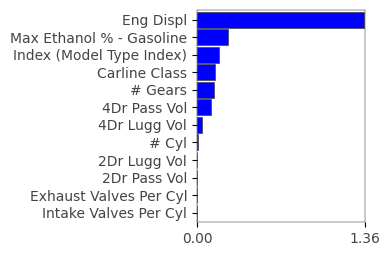

In [1258]:
# now we'll create and evaluate our baseline model
rf_baseline,oob1=evaluate(X_num,y)
showimp(rf_baseline,X_num,y)
print('Only numeric features baseline model')

***
Once we evaluated our first baseline model, altough the oob score was not extremely high we tested removing different features to see if there was anyone producing erroneous high scores. we found no real difference and the more important ones seemed to make sense, so we kept working with them.
***

### Part 3 - Convert all features to numeric and handle missing values (20 marks)

In this part you should: 
 - only use ordinal encoding 
 - convert **all** non-numeric features to numeric 
 - handle any missing values in any feature
 - assume all missing data has already been normalized appropriately

In [1259]:
# pulling out non-numeric features
X_nonum=X.select_dtypes(exclude='number')
# save column names in a separated variable
nonum_features=X_nonum.columns.tolist()
# converting non-numeric features to numeric using our handy functions
# first, check what kind of values these features have
get_unique_values_in_columns(X_nonum)


PRINTING UNIQUE VALUES PER COLUMN

Mfr Name : Mfr Name
general motors          160
bmw                     141
chrysler group llc      105
ford motor company      100
toyota                   90
mercedes-benz            82
nissan                   79
porsche                  51
volkswagen               48
audi                     48
honda                    43
hyundai                  38
kia                      35
jaguar land rover l      33
mazda                    25
subaru                   23
mitsubishi motors co     18
ferrari                  13
volvo                    13
rolls-royce               7
lamborghini               7
bentley                   7
roush                     7
aston martin              7
maserati                  6
lotus                     4
mclaren automotive        2
mobility ventures l       2
bugatti                   1
pagani automobili s       1
Name: count, dtype: int64 ['aston martin' 'audi' 'bmw' 'bugatti' 'general motors' 'ferrari' 'honda'
 'jag

***
we found some different values that could be considered missing values (nan, ??, mod, "not applicable" and "not applicable."), We weren't sure about how to proceed here because the instruction was just assuming that data was already properly normalized then we'll just encode features to make them numeric, but we've been told too to not assume anything so we decided to propery normalized the data.
***

In [1260]:
# --------------- normalizing missing values to NaN in non numeric features -----------------
missing_values_str=['??',r'/\s+/','mod','not applicable', 'not applicable.']
X_encoded=X_nonum.copy()  # we'll uset X_nonum later to try different encoders
normalize_nonum(X_encoded,missing_values_str)

# using our functions to convert columns dtype from string (in this case is object) to category
# and then assign numeric values to every different category created in the previous step
df_cat_to_catcode(df_string_to_cat(X_encoded))

# ------------------ normalizing missing values in numeric features -----------------
X_num=normalize_num(X_num)
# handling missing values in numeric columns by replacing them with that column median value. 
fix_missing_num(X_num)


### Part 4 - Create and evaluate a new baseline (5 marks)

In this part you should:
 - create and evaluate a model using all the features, that is, after converting everything to numeric and handling missing values

Mean OOB score: 0.930867895433178
193,706 tree nodes and 23.0 median tree height
2nd baseline model improved in 5.393065302816893 %


,Importance
Feature,
Eng Displ,1.164803
Label Recalc?,0.059196
Off Board Charge Capable (Y or N),0.057042
Carline Class,0.039118
Oil Viscosity,0.030502
Fuel Metering Sys Cd,0.024380
Fuel Metering Sys Desc,0.021761
Carline Class Desc,0.018596
Fuel Cell Vehicle (Y or N),0.017618


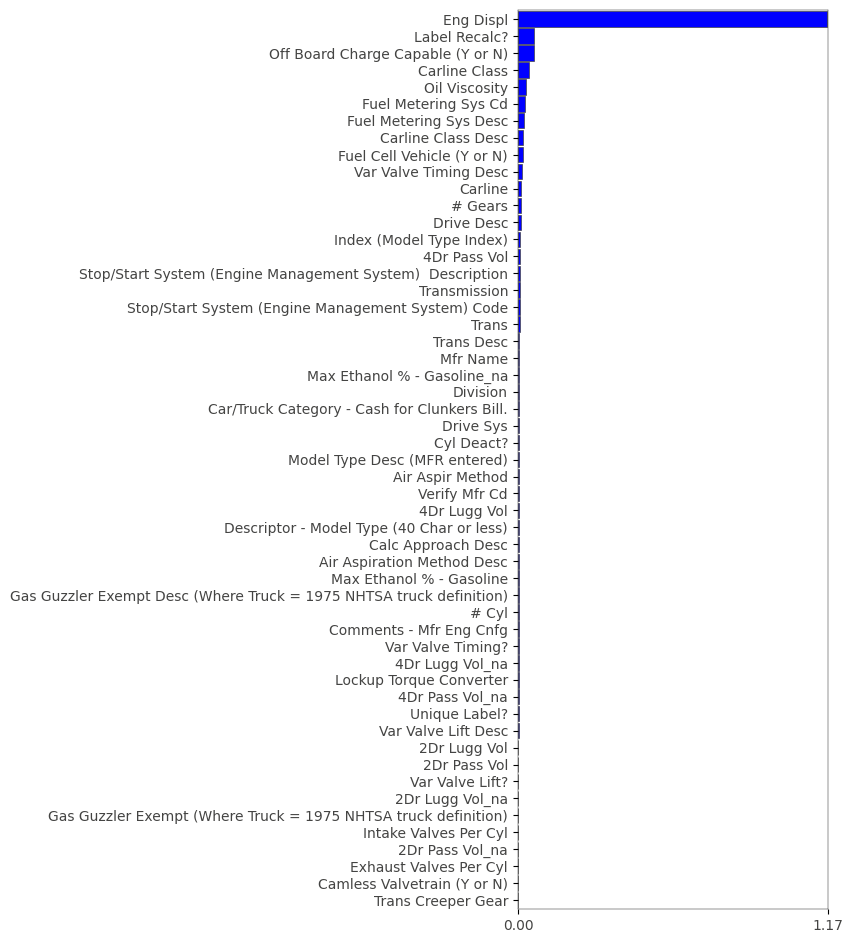

In [1261]:
# putting initial numeric features and the now-encoded non-numeric features all together in one dataset to create a new baseline model
X_full=pd.concat([X_num,X_encoded],axis=1)
rf_baseline2,oob2=evaluate(X_full,y)
I=showimp(rf_baseline2,X_full,y)
print(f'2nd baseline model improved in {(oob2*100/oob1)-100} %')
I

**Question** Did the performance of the model improve compared to the results of **Part 2**?

***
**Answer:** yes, there was an improvement slightly over 5 % after adding encoded features.
***

### Part 5 - How high can you go? (15 marks)

How high can you get the oob score above the new baseline of **Part 4**? See how much improvement you can squeeze out of the data. 

**For this part, do NOT do any hyper-parameter tuning.**

Some things to try to get started:
 - are some features not important so can be dropped without impacting performance?
 - do other encodings work better than ordinal for some features?  
 - any feature engineering that will help? 
 - any external data that could be included?

 ***
 ### NOTE:
 In this step, we experimented many different things trying to improve our model performance, most relevant test cases results are documented in **Part 7 Table**, here, we just left the ones we'll use to build our final model.

In [1262]:
# dropping less important features
X_full=X_full.drop(I[I['Importance']<.003].index,axis=1)

In [1263]:
# Dropping dataset rows corresponding to missing values in target feature
dfdr=pd.concat([X_full,y], axis=1)
dfdr.drop(dfdr[(dfdr[target_feature[0]]==0)].index,axis=0, inplace=True)
Xdr,ydr=dfdr.drop(target_feature[0],axis=1),dfdr[target_feature[0]]

### Part 6 - Create and evaluate a final model (10 marks)

In this part you should:
 - create and evaluate a model using only the features that give the best results after the exploration done in Part 4 

Mean OOB score: 0.9499664212745988
193,308 tree nodes and 22.0 median tree height
Final model show improvement in 2.0516902489727897 % compared to 2nd baseline model


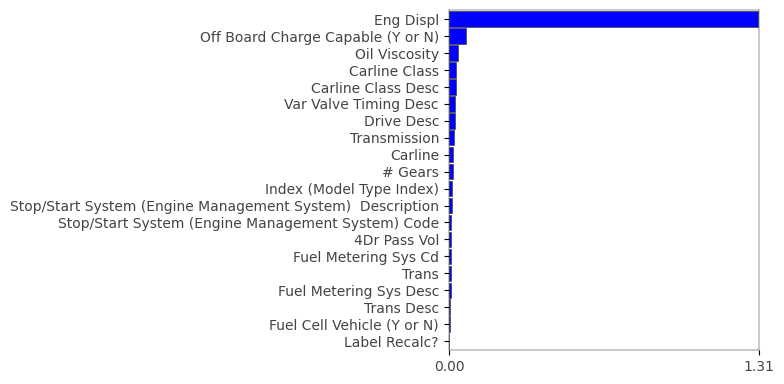

In [1264]:
rf,oob3=evaluate(Xdr,ydr)
showimp(rf,Xdr,ydr)
print(f'Final model show improvement in {(oob3*100/oob2)-100} % compared to 2nd baseline model')


### Part 7 - How did you do? (15 marks)

**Question** What is the percent difference between the oob score of your best model and the baseline calculated in **Part 4**?

***
**Enter your answer here:**
Our final model performed around 2 % better than the 2nd baseline model.
***

**Question** What changes did you make to the data set of **Part 4** to get to the final data set used in **Part 6** and how much did each change increase the oob score that you calculated in **Part 4**? 
***
**Answer** We applied 2 changes:
- dropping less important features from dataset.
- dropping rows according to missing values in target feature.

Impact of those changes in model's performance were: 0.6% and 1.5% respectively.
***

**Enter your answer here:**

| Change made in vector features| Change in oob score | 
| :- | :-: |  
|  Dropped 2 features: ``"Off Board Charge Capable (Y or N)"``,``"Fuel Cell Vehicle (Y or N)"`` because they had only 2 values, one of them coming from missing values category before encoding so we thought they may affect negatively model's preditive ability. Turned out that we were wrong.   | -0.008    | 
|  Used one-hot encoder with ``'Trans', 'Drive Sys', 'Calc Approach Desc', and 'Air Aspiration Method Desc'``, encoding them isolated and simultaneously, isolated, results were negative and simultaneously we could get some trivial improvement, not > 9e-4 | +0.0008    | 
|  With tested dropping `Trans Desc, Drive Desc, and Gas Guzzler Exempt Desc (Where Truck = 1975 NHTSA truck definition)`, because they seemed to be duplicated date, cause they were like Description fields for other categorical values and their uniques values counts where the same, nevertheless, we got no significative improvements. In general terms we observed high variability between improvement/worsen when difference absolute value is lower than 1e-3 | <0.0009    | 
|  We tried dropping different features according to their importances, we found the best results when dropping those ones with importance value < .003~.004  | +0.0087    | 
***
| Change made in target feature| Change in oob score | 
| :- | :-: |  
|  We had missing values in our target feature, so we tried different things, first, we used it as we did with baseline model (missing values filled in with 0's)  | baseline   | 
|  Replacing missing values with median  | +0114 | 
|  Replacing missing values with mean  | +0117 | 
|  Dropping dataset rows corresponding to missing values in target feature  | +0156 | 
